This notebook allows to reproduce the paper synthetic results. First, we create a synthetic population with different disease expression. Then, we enforce missingness following three scenario of clinical presence, i.e. the interaction between patient and the healthcare system:
- (Mis)-informed collection
- Limited access to quality care
- Confirmation bias

In [1]:
from utils import *
import numpy as np

In [2]:
# Number of random repetitions
k = 100

### Generate data

First, we create the data from three gaussian: one for positives and two for negatives (one for the minority and one for the majority). This same function is then called at each $k$ iteration.

/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


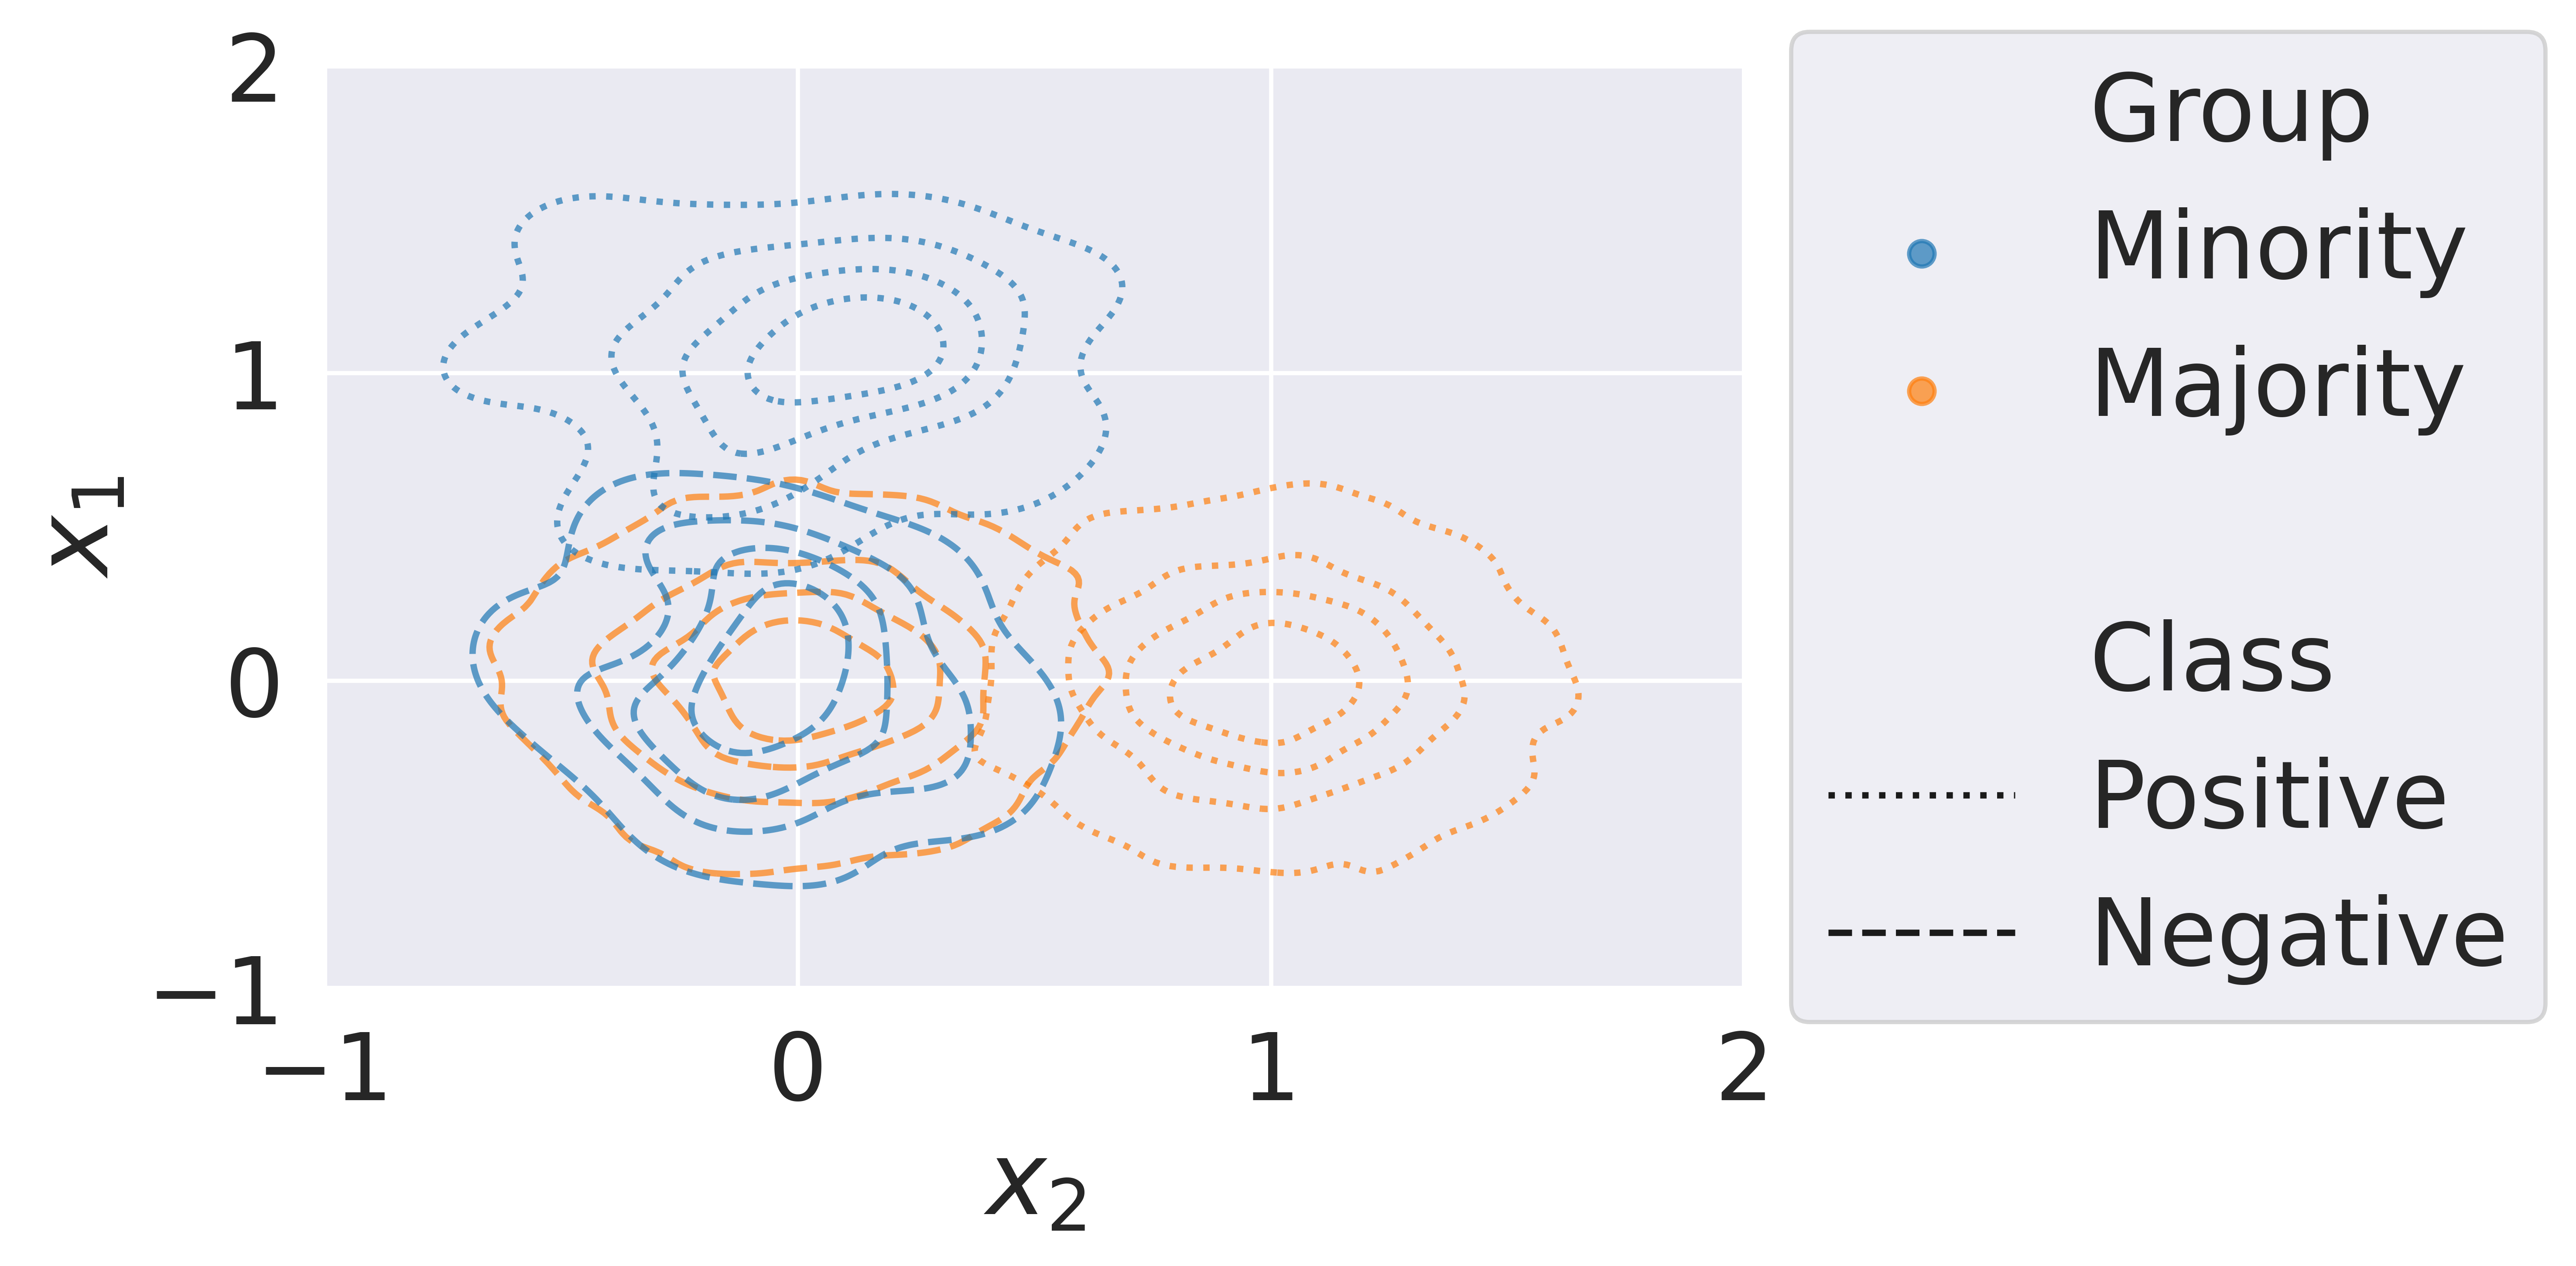

In [3]:
data, labels, protected_binarized, protected = generate_data_linear_shift(majority_size = 10000, ratio = 0.01)
display_data(data, labels, protected, distribution = True, legend = True)

In [4]:
# Imputations strategies to explore
imputations = {
                'Complete Case': {'strategy': 'Median', 'complete_case': True},
                'Median': {'strategy': 'Median'},
                'Median Missing': {'strategy': 'Median', 'add_missing': True},
                'MICE': {'strategy': 'MICE'},
                'MICE Missing': {'strategy': 'MICE', 'add_missing': True},
                'Group MICE': {'strategy': 'Group MICE'},
                'Group MICE Missing': {'strategy': 'Group MICE', 'add_missing': True}, 
              }

### Limited access to quality care

Care is more limited in the marginalised group. Missingness is therefore concentrated in this group.

In [5]:
def limited_access(data, labels, protected, seed = 42):
    p = (protected == "Minority").astype(float) # All minority
    total = p.sum()
    selection = data.sample(int(total * 0.5), replace = False, weights = p / total, random_state = seed).index # 50 % missing
    missing = data.copy()
    missing.loc[selection, 0] = np.nan
    return missing

In [6]:
# Variable for results
performance_lim = {}

for name, args in imputations.items():
    print("Computing: ", name)
    ## Modelling
    performance_lim[name], coefs, imputed = k_experiment(majority_size = 10000, ratio = 0.01, class_balance = 0.5, 
            removal = limited_access, k = k, n_imputation = 10 if 'MICE' in name else 1, **args)

    ## Display
    # data, imputed, labels, protected_binarized, protected = imputed
    # display_data(imputed.Mean, labels, protected, distribution = True, legend = False)
    # plt.scatter([], [], alpha = 0, label = ' ')
    # plt.axline((0, coefs[0]), slope = coefs[1], c = 'black', ls = '-.', label = 'Decision boundary')
    # if name == 'Group MICE':
    #     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.show()

Computing:  Complete Case


100%|██████████| 100/100 [00:04<00:00, 23.55it/s]


Computing:  Median


100%|██████████| 100/100 [00:05<00:00, 19.56it/s]


Computing:  Median Missing


100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


Computing:  MICE


100%|██████████| 100/100 [02:35<00:00,  1.55s/it]


Computing:  MICE Missing


 15%|█▌        | 15/100 [00:30<02:54,  2.05s/it]


KeyboardInterrupt: 

In [ ]:
display_result(performance_lim, alphas = [0.35, 0.35, 1, 1])

In [ ]:
display_result(performance_lim, 'Brier Score', legend = False, alphas = [0.35, 0.35, 1, 1])

### Mis-informed collection

Missingness is informed by the standard guidelines. We propose that the first dimension is observed only if the second is in a given range.

In [ ]:
def misinformed(data, labels, groups, seed = 42): # Must respect this signature
    p = (data.iloc[:, 1] > 0.5).astype(float) # All above threshold
    total = p.sum()
    selection = data.sample(int(total * 0.5), replace = False, weights = p / total, random_state = seed).index
    missing = data.copy()
    missing.loc[selection, 0] = np.nan
    return missing

In [ ]:
# Variable for results
performance_mis = {}

for name, args in imputations.items():
    print("Computing: ", name)
    ## Modelling
    performance_mis[name], coefs, imputed = k_experiment(majority_size = 10000, ratio = 0.01, class_balance = 0.5, 
            removal = misinformed, k = k, n_imputation = 10 if 'MICE' in name else 1, **args)

    ## Display
    # data, imputed, labels, protected_binarized, protected = imputed
    # display_data(imputed.Mean, labels, protected, distribution = True, legend = False)
    # plt.scatter([], [], alpha = 0, label = ' ')
    # plt.axline((0, coefs[0]), slope = coefs[1], c = 'black', ls = '-.', label = 'Decision boundary')
    # if name == 'Group MICE':
    #     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.show()

In [ ]:
display_result(performance_mis, alphas = [0.35, 0.35, 1, 1])

In [ ]:
display_result(performance_mis, 'Brier Score', legend = False, alphas = [0.35, 0.35, 1, 1])

### Confirmation bias

Test is performed when the outcome is expected.

In [7]:
def confirmation(data, labels, protected, seed = 42):
    p = ((data.iloc[:, 1] < 0.5) & (data.iloc[:, 0] < 0.5)).astype(float) # All negatives
    total = p.sum()
    selection = data.sample(int(total * 0.5), replace = False, weights = p / total, random_state = seed).index # 50 % missing
    missing = data.copy()
    missing.loc[selection, 0] = np.nan
    return missing

In [8]:
# Variable for results
performance_conf = {}

for name, args in imputations.items():
    print("Computing: ", name)
    ## Modelling
    performance_conf[name], coefs, imputed = k_experiment(majority_size = 10000, ratio = 0.01, class_balance = 0.5, 
            removal = confirmation, k = k, n_imputation = 10 if 'MICE' in name else 1, **args)

    ## Display
    # data, imputed, labels, protected_binarized, protected = imputed
    # display_data(imputed.Mean, labels, protected, distribution = True, legend = False)
    # plt.scatter([], [], alpha = 0, label = ' ')
    # plt.axline((0, coefs[0]), slope = coefs[1], c = 'black', ls = '-.', label = 'Decision boundary')
    # if name == 'Group MICE':
    #     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.show()

Computing:  Complete Case


100%|██████████| 100/100 [00:04<00:00, 20.15it/s]


Computing:  Median


100%|██████████| 100/100 [00:04<00:00, 22.40it/s]


Computing:  Median Missing


100%|██████████| 100/100 [00:05<00:00, 18.19it/s]


Computing:  MICE


100%|██████████| 100/100 [02:23<00:00,  1.44s/it]


Computing:  MICE Missing


 18%|█▊        | 18/100 [00:31<02:49,  2.07s/it]

In [ ]:
display_result(performance_conf, alphas = [0.35, 0.35, 1, 1])

In [ ]:
display_result(performance_conf, 'Brier Score', alphas = [0.35, 0.35, 1, 1])

----------

# Comparison minority groups

This following functions allow to reproduce the table and plots presented in the paper.

In [ ]:
performances_minority = {m:
    pd.concat({
        "Confirmation bias (S3)": performance_conf[m]['Minority'],
        "(Mis)-Informed collection (S2)": performance_mis[m]['Minority'],
        "Limited access to quality care (S1)": performance_lim[m]['Minority'],
    }, axis = 1)
for m in performance_lim}

performances_overall = {m:
    pd.concat({
        "Confirmation bias (S3)": performance_conf[m]['Overall'],
        "(Mis)-Informed collection (S2)": performance_mis[m]['Overall'],
        "Limited access to quality care (S1)": performance_lim[m]['Overall'],
    }, axis = 1)
for m in performance_lim}

In [ ]:
def display_result(performance, type = 'AUC', legend = True, colors = ['tab:orange', 'tab:blue', 'tab:gray'], alphas = None):
    mean, ci = {}, {}
    for method in performance:
        mean[method], ci[method] = {}, {}
        for group in performance[method].columns:
            meth_group = performance[method][group]
            meth_group = meth_group[meth_group.index.get_level_values('Metric') == type]
            mean[method][group] = meth_group.mean()
            ci[method][group] = 1.96 * meth_group.std() / np.sqrt(len(meth_group))

    mean, ci = pd.DataFrame.from_dict(mean), pd.DataFrame.from_dict(ci)
    print(pd.DataFrame.from_dict({m: ["{:.3f} ({:.3f})".format(mean.loc[m].loc[i], ci.loc[m].loc[i]) for i in mean.columns] for m in mean.index}, columns = mean.columns, orient = 'index').to_latex())
    
    fig, axes = plt.subplots(nrows = 1, ncols = len(colors), sharex = True, sharey = True)
    mean.T.plot.bar(ax = axes, xerr = ci.T, legend = False, figsize = (20, 7), subplots = True, width = 0.8)

    # Change colors
    hatches = ['', 'ooo', 'xx', '//', '||', '***', '++']
    for j, ax in enumerate(axes):
        for i, thisbar in enumerate(ax.patches):
            c = list(plt_colors.to_rgba(colors[j]))
            c[3] = alphas[i] if alphas is not None else 1
            thisbar.set(edgecolor = '#eaeaf2', facecolor = c, linewidth = 1, hatch = hatches[i])    

    if legend:
        ncol = len(np.unique(colors))
        patches = [ax.patches[i * len(mean) + j] for j in range(ncol) for i in range(len(mean.columns))][::-1]
        labels = [''] * (len(patches) - len(mean.columns)) + mean.columns.tolist()[::-1]
        ax.legend(patches, labels, loc='center left', bbox_to_anchor=(1, 0.5),
            title = 'Imputation strategies', ncol = ncol, handletextpad = 0.5, handlelength = 1.0, columnspacing = -0.5,)

display_result(performances_minority, colors = ['tab:blue', 'tab:blue', 'tab:blue'], alphas = [0.35, 0.35, 1, 1])

In [ ]:
def display_result(performance, type = 'AUC', legend = True, colors = ['tab:orange', 'tab:blue', 'tab:gray'], alphas = None, overall_perf = None):
    mean, ci, dots, dots_ci = {}, {}, {}, {}
    for method in performance:
        mean[method], ci[method], dots[method], dots_ci[method] = {}, {}, {}, {}
        for group in performance[method].columns:
            meth_group = performance[method][group]
            meth_group = meth_group[meth_group.index.get_level_values('Metric') == type]

            if overall_perf is not None:
                meth_all = overall_perf[method][group]
                meth_all = meth_all[meth_all.index.get_level_values('Metric') == type]
                dots[method][group] = meth_all.mean()
                dots_ci[method][group] = 1.96 * meth_all.std() / np.sqrt(len(meth_all))

            mean[method][group] = meth_group.mean()
            ci[method][group] = 1.96 * meth_group.std() / np.sqrt(len(meth_group))

    mean, ci, dots, dots_ci = pd.DataFrame.from_dict(mean), pd.DataFrame.from_dict(ci), pd.DataFrame.from_dict(dots), pd.DataFrame.from_dict(dots_ci)
    print(pd.DataFrame.from_dict({m: ["{:.3f} ({:.3f})".format(mean.loc[m].loc[i], ci.loc[m].loc[i]) for i in mean.columns] for m in mean.index}, columns = mean.columns, orient = 'index').to_latex())
    ax = mean.plot.barh(xerr = ci, legend = legend, figsize = (7, 7), width = 0.75)
    # Change colors
    hatches = ['', 'ooo', 'xx', '//', '||', '***', '++']
    for i, thisbar in enumerate(ax.patches):
        c = list(plt_colors.to_rgba(colors[i % len(mean)]))
        c[3] = 1 if alphas is None else alphas[i // len(mean)]
        thisbar.set(edgecolor = '#eaeaf2', facecolor = c, linewidth = 1, hatch = hatches[i // len(mean)])

        if overall_perf is not None:
            y = thisbar.get_y() + thisbar.get_height() / 2
            plt.plot([dots.values[i % len(mean)][i // len(mean)] - dots_ci.values[i % len(mean)][i // len(mean)], dots.values[i % len(mean)][i // len(mean)] + dots_ci.values[i % len(mean)][i // len(mean)]], [y, y], alpha = 0.5)
            scatter = plt.scatter(dots.values[i % len(mean)][i // len(mean)], y, c = 'tab:gray', label = 'Population ' + type, alpha = 0.5, s = 100)
        
    plt.grid(alpha = 0.3)
    
    if type == 'AUC':
        plt.xlim(0.2, 1.0)
        plt.axvline(0.5, ls = ':', c = 'k', alpha = 0.5)
    else:
        plt.xlim(0., 0.8)
    plt.xlabel(type)

    if legend:
        ncol = len(np.unique(colors))
        patches = [ax.patches[i * len(mean) + j] for j in range(ncol) for i in range(len(mean.columns))][::-1]
        labels = [''] * (len(patches) - len(mean.columns)) + mean.columns.tolist()[::-1] 
        
        if dots is not None:
            patches += [plt.scatter([], [], label = ' ', alpha = 0), scatter]
            labels  += ['', 'Population ' + type]

        ax.legend(patches, labels, loc='center left', bbox_to_anchor=(1, 0.5),
            title = 'Imputation strategies', ncol = ncol, handletextpad = 0.5, handlelength = 1.0, columnspacing = -0.5,)

display_result(performances_minority, colors = ['tab:blue', 'tab:blue', 'tab:blue'], alphas = [0.35, 0.35, 1, 1], overall_perf = performances_overall)

In [ ]:
display_result(performances_overall, colors = ['tab:blue', 'tab:blue', 'tab:blue'], alphas = [0.35, 0.35, 1, 1])